In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
import sys
import os


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import yaml
import torch
import numpy as np

from dqn.opinion_dynamics.opinion_dqn import AgentDQN
from dqn.opinion_dynamics.utils.my_logging import setup_logger
from dqn.opinion_dynamics.utils.experiment import build_environment
from dynamic_programming.opinion_dynamics.common.viz import (
    interpolate_opinion_trajectory,
    plot_action_heatmap,
    plot_opinions_over_time,
)


def instantiate_agent(exp_subdir_path: str) -> AgentDQN:
    """
    Instantiate an AgentDQN using the configuration stored in a YAML file
    in the provided experiment subdirectory. The agent is created with the
    given training and validation environments and loads its previous state.

    Args:
        exp_subdir_path (str): Path to the experiment subdirectory containing the config YAML and checkpoint files.


    Returns:
        AgentDQN: An instance of AgentDQN initialized using the experiment configuration and saved state.
    """
    # Assume the YAML configuration is stored as 'config.yaml' in the experiment folder.
    config_path = os.path.join(exp_subdir_path, "cfg.yaml")
    if not os.path.exists(config_path):
        raise FileNotFoundError(f"Config file not found at {config_path}")

    with open(config_path, "r") as f:
        config = yaml.safe_load(f)

    # Instantiate the agent.
    # The resume_training_path is set to the experiment folder so that the agent loads saved weights/stats.
    agent = AgentDQN(
        resume_training_path=exp_subdir_path,
        experiment_name=config["experiment"],
        config=config,
        save_checkpoints=False,  # you can set this as needed
        logger=setup_logger("dqn"),
    )

    return agent


def run_policy_agent(agent, max_steps=1000):
    """
    Run the simulation using the agent’s policy (exploitation only).

    Args:
        env: The environment (which must have a reset and step method).
        agent: An already-trained AgentDQN instance.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions (states) over time.
        time_points: Array of time stamps.
        rewards_over_time: Array of rewards collected at each step.
        actions_over_time: Array of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []
    opinions_over_time = []
    env = agent.validation_env

    current_time = 0.0
    # Reset environment
    state, _ = env.reset()
    opinions_over_time.append(state.copy())

    for step in range(max_steps):
        # Convert state to a batched tensor (batch size = 1)
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        # Use the agent in exploitation mode (epsilon=0, random_action=False)
        # The agent.select_action returns (action, beta_idx, q_value)
        action, _, _, _ = agent.select_action(
            state_tensor, epsilon=0.0, random_action=False
        )
        # action is returned as a NumPy array with shape (1, n_agents)
        action = np.squeeze(action)  # Now action has shape (n_agents,)
        actions_over_time.append(action.copy())

        # Apply the action in the environment.
        next_state, reward, done, truncated, _ = env.step(action, env.tau)
        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)

        current_time += env.tau
        state = next_state

        if done or truncated:
            break

    print(f"Simulation ended at step {step}: done={done}, truncated={truncated}")
    return (
        np.array(opinions_over_time),
        np.array(time_points),
        np.array(rewards_over_time),
        np.array(actions_over_time),
    )

2025-07-02 00:46:44,890 - dqn - INFO - opinion_dqn.py:266 - Loaded configuration settings.
2025-07-02 00:46:44,898 - dqn - INFO - opinion_dqn.py:328 - Initialized networks and optimizer.
2025-07-02 00:46:50,798 - dqn - INFO - opinion_dqn.py:211 - Loaded previous training status from the following files: {'replay_buffer_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul01-141613_configs\\0003_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_8\\2\\opinion_agent_dqn_replay_buffer', 'train_stats_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul01-141613_configs\\0003_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_8\\2\\opinion_agent_dqn_train_stats', 'checkpoint_model_file': 'd:\\Work\\repos\\RL\\phd-rl-algos\\dqn\\opinion_dynamics\\experiments\\results\\2025Jul01-141613_configs\\0003_agent_params.args_.target_model_update_freq_500

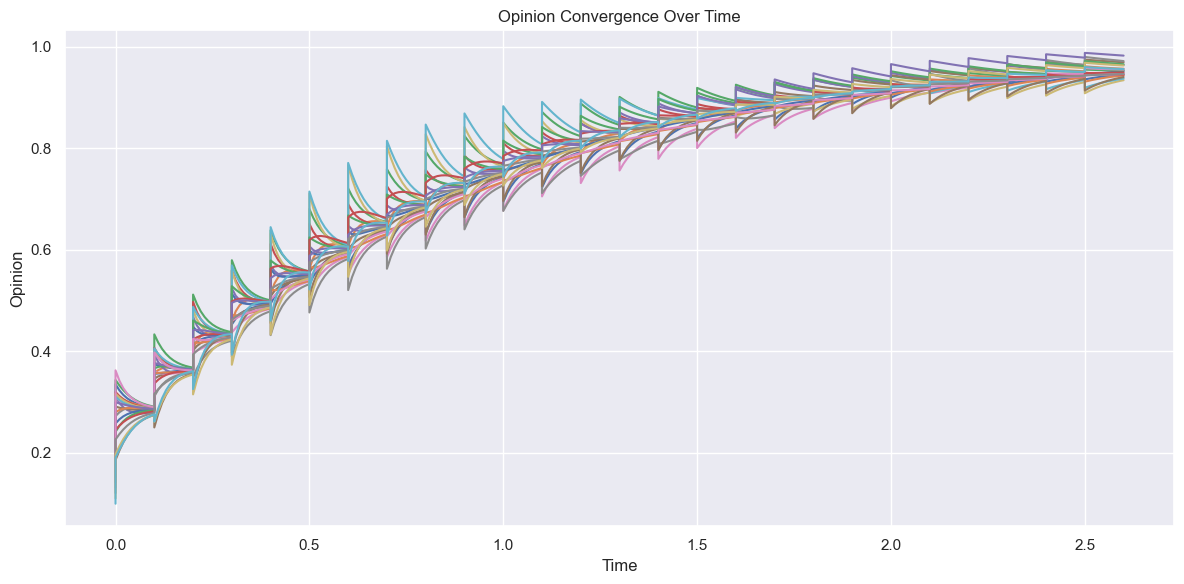

In [47]:
# best performing
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Apr22-104437_configs\0003_agent_params.args_.action_w_noise_amplitude_0.6\0"

# last run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May02-101004_configs\0025_optim.args_.eps_1e-07__optim.args_.lr_1e-05__agent_params.args_.target_model_update_freq_500__agent_params.args_.training_freq_4__agent_params.args_.batch_size_32__agent_params.args_.action_w_noise_amplitude_0.3\1" # excellent run

# was a decent run
# exp_subdir = r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May29-012929_configs\0000_optim.args_.lr_1e-05__agent_params.args_.action_w_noise_amplitude_0.5__agent_params.args_.target_model_update_freq_1000\1"

exp_subdir = r"d:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Jul01-141613_configs\0003_agent_params.args_.target_model_update_freq_5000__agent_params.args_.training_freq_8\2"

agent = instantiate_agent(exp_subdir)

max_steps = 30
states, times, rewards, actions = run_policy_agent(agent, max_steps=max_steps)

interpolated_states, interpolated_times = interpolate_opinion_trajectory(
    env=agent.validation_env,
    opinions_over_time=states,
    actions=actions,
    n_substeps=10,  # increase for smoother curves
)

# Plot the smooth trajectory
plot_opinions_over_time(interpolated_states, interpolated_times)

In [48]:
len(actions)

26

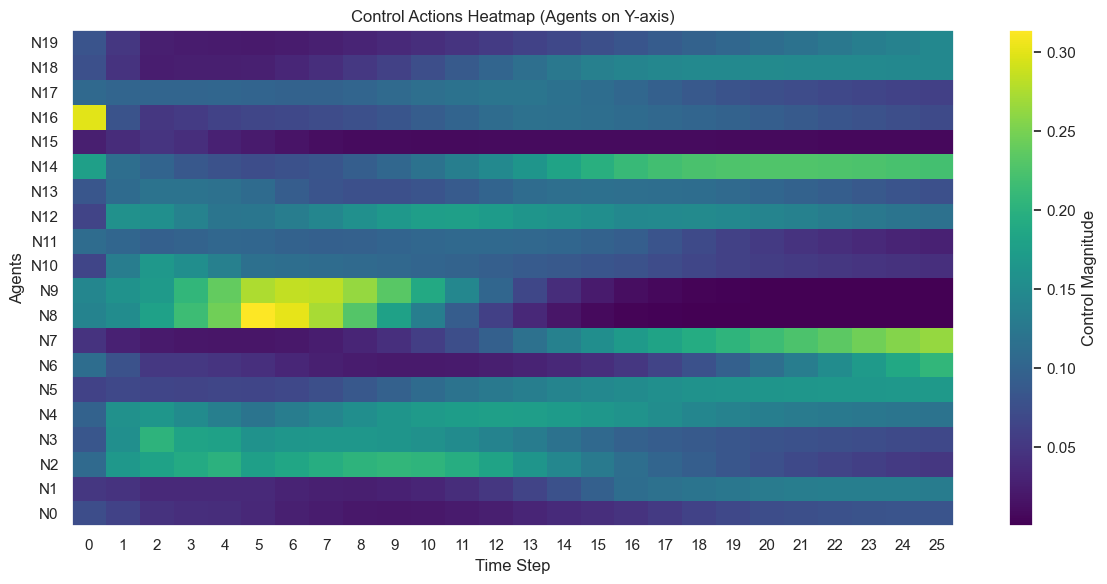

In [49]:
plot_action_heatmap(actions)

In [50]:
gamma = 0.99
total_value = 0
for i, r in enumerate(rewards):
    total_value = total_value + (gamma**i) * r

total_value

-7.298027620113067

In [51]:
# Add multiple budget levels
# Retrieve the budget levels used and plug into NAHS control



In [52]:
sum(rewards)

-7.7850068485051995